In [606]:
import os
import tables
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [146]:
def set_device():
    """
    Set the device. CUDA if available, CPU otherwise

    Args:
        None

    Returns:
        Nothing
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is disabled in this notebook. Devide is set to CPU.")
    else:
        print("GPU is enabled in this notebook. Devide is set to GPU.")

    return device

device = set_device()

GPU is disabled in this notebook. Devide is set to CPU.


In [4]:
T = 10 # time buckets

hdf5 = tables.open_file('G:/Outros computadores/Desktop/Faculdade/Mestrado/NNC/GitHub/Neuromatch/Project/data/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('G:/Outros computadores/Desktop/Faculdade/Mestrado/NNC/GitHub/Neuromatch/Project/data/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('G:/Outros computadores/Desktop/Faculdade/Mestrado/NNC/GitHub/Neuromatch/Project/data/cache.npy', dataset)

classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

In [8]:
import collections

values = {}                                                         # Dictionary to store the number of photos per individual
index_14 = []                                                       # List to store the 14 individual indexes (for example)

for index, feature in enumerate(classes):                           # Run through the classes
    individual = feature[0]                                         # Get the individual's number                                   
    photo = feature[1]                                              # Get the photo's number
    if individual in values:                                        # If the individual is already in the dictionary         
        values[individual].append(photo)                            # Add the photo to the list of photos
    else:                                                           # If the individual is not in the dictionary
        values[individual] = [photo]                                # Add the individual and the photo to the dictionary
    if individual == 14:                                            # If the individual's number is 14
        index_14.append(index)                                      # Add the index to a list

for individual in values.keys():                                    # Run through the dictionary
    values[individual].sort()                                       # Sort the list of photos

values = dict(collections.OrderedDict(sorted(values.items())))      # Sort the dictionary by individual's number

print('Classes shape: \n' + str(classes.shape))
print('Classes: \n' + str(classes.T))

print('\nFor classes we have 14 labels and each labels have a range of values from 1 to 200')
print('This labels represents 14 different photos of 200 different individuals')
print('\nClasses organization example (dictionary key 14): \n' + 'Individual 4: ' + str(values[4]))


Classes shape: 
(2800, 2)
Classes: 
[[ 41 111 144 ... 144  82 148]
 [  2  11  10 ...   2  12   1]]

For classes we have 14 labels and each labels have a range of values from 1 to 200
This labels represents 14 different photos of 200 different individuals

Classes organization example (dictionary key 14): 
Individual 4: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
imgs = hdf5["images"][0:100]                                    # Gets the first 100 images
y,x = np.where(np.mean(imgs, axis=(0,3))>5)                     # Finds a mean threshold to cut the image
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)      # Gets the black borders indexes
images = hdf5["images"][:,ytop:ybot,xleft:xright]               # Cuts the image and gets out the black borders (all 2800 images)

tiny_images = []
for i in range(len(images)):                                    # Runs in all images
    tiny_images.append(cv2.resize(images[i],(64,64)))           # Resizes the image
images = np.stack(tiny_images)                                  # Joins a sequence of arrays into a single array

Imgs shape: 
(100, 800, 1280, 3)
Images shape: 
(2800, 64, 64, 3)

Images are cropped and resized to 64x64 pixels as in this example below:


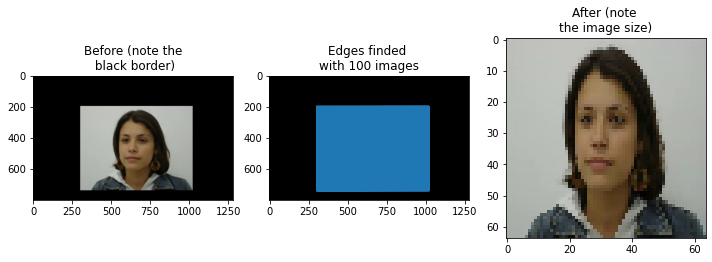


Photos of Individual 14:


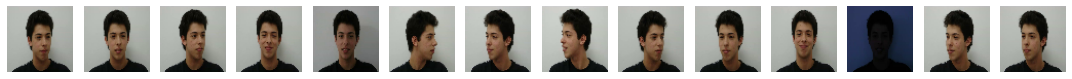

In [132]:
print('Imgs shape: \n' + str(imgs.shape))
print('Images shape: \n' + str(images.shape))

print('\nImages are cropped and resized to 64x64 pixels as in this example below:')

figure_0, axes = plt.subplots(1,3, figsize=(10, 10))
axes[0].set_title('Before (note the\n black border)')
axes[0].imshow(imgs[7])
axes[1].set_title('Edges finded \nwith 100 images')
axes[1].imshow(imgs[7])
axes[1].plot(x,y)
axes[2].set_title('After (note \nthe image size)')
axes[2].imshow(images[7])
plt.tight_layout()
plt.show()

figure_1, axes = plt.subplots(1,14, figsize=(15, 15), sharex=True, sharey=True) 
print("\nPhotos of Individual 14:")
for axe, index in zip(axes, index_14):
    axe.imshow(images[index])
    axe.axis('off')
plt.tight_layout()
plt.show()

In [353]:
class set_data(Dataset):
    def __init__(self, data_dict, train=True):
        self.input_dict = data_dict
        
        self.images_train, self.images_test, self.labels_train, self.labels_test = train_test_split(self.input_dict['input_images'],
                                                                   self.input_dict['input_labels'], test_size=0.20, random_state=42)
        
        if train:
            self.labels = self.labels_train
            self.input_array = self.images_train
        else:
            self.labels = self.labels_test
            self.input_array = self.images_test
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (np.float32(np.squeeze(self.input_array[idx,:,:])), self.labels[idx])
        return sample

In [459]:
data_spikes = torch.from_numpy(dataset)
data_classes = torch.from_numpy(classes)
data_images = torch.from_numpy(images).permute(0,3,1,2).float()
data_labels = data_classes.T[0].long() - 1
data_labels = torch.nn.functional.one_hot(data_labels, num_classes=- 1).float()
data_dict = {'input_images': data_images, 'input_labels': data_labels}

#data = set_data(data_dict, train=True)

In [627]:
class classification_net(nn.Module):
    def __init__(self):
        
        super(classification_net, self).__init__()

        # Input size = [64, 64] in 3 channels
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Output size = ([64, 64] - [5-1, 5-1])/2 = [30,30] in 16 channels

        # Input size = [30, 30] in 16 channels
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Output size = ([30, 30] - [3-1, 3-1])/2 = [14, 14] in 32 channels

        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(14*14*32, 2000)  
        #self.linear2 = nn.Linear(2000, 800)
        self.linear3 = nn.Linear(2000, 200)

    def forward(self, x):
        out = self.layer1(x)                                # Passes the image through the 1st convolutional layer ()      
        out = self.layer2(out)                              # Passes the image through the 2nd convolutional layer ()
        out = out.reshape(out.size(0), -1)                  # Flattens the output of the convolutional layer
        out = self.dropout(out)                             # Applies dropout to the output of the last layer
        out = self.linear1(out)                             # Passes the output of the last layer through the 1st linear layer
        out = self.relu(out)                                # Applies the ReLU activation function 
        out = self.dropout(out)                             # Applies dropout to the output of the last layer
        #out = self.linear2(out)                             # Passes the output of the last layer through the 2nd linear layer
        #out = self.relu(out)                                # Applies the ReLU activation function
        #out = self.dropout(out)                             # Applies dropout to the output of the last layer
        out = self.linear3(out)                             # Passes the output of the last layer through the 3rd linear layer
        #out = nn.functional.softmax(out, dim=1)             # Gets the most likely class
    
        return out                                          # Returns the output of the last layer

In [628]:
class model_handler():
    def __init__(self, model, input_dict, reg ="l1"): 
        # super(Run_model,self).__init__()
        self.model = model
        self.device = "cpu"
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = 0.0001
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        self.reg = reg
        # Hyperparameters
        self.num_epochs = 15
        self.num_classes = np.unique(input_dict['input_labels']).shape[0]
        self.batch_size = 100
        self.input_dict = input_dict
        self.train_data = set_data(data_dict=self.input_dict, train=True)
        self.test_data = set_data(data_dict=self.input_dict, train=False)
        # Data loader
        self.train_loader = DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader  = DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False)
        self.activation = {}
        # self.le = preprocessing.LabelEncoder()
        # self.le.fit(self.input_dict['labels_name'])
        # print(np.unique(input_dict['labels_name']))
        # print(np.unique(vars(self.motion_test)["labels"]))
        # self.test_labels_name = le.inverse_transform(vars(self.motion_test)["labels"])
        # self.train_labels_name =  le.inverse_transform(vars(self.motion_train)["labels"])
        

    def train(self):
        total_step = len(self.train_loader)
        self.train_loss_list = []
        self.train_accurace_list = []
        for epoch in range(self.num_epochs):
            for i, (image, label) in enumerate(self.train_loader):
                image, label = image.to(self.device), label.to(self.device)

                # Run the forward pass
                output = self.model(image)
                self.loss = self.loss_fn(output, label)

                # add regularization
                reg_lambda = 0.001
                if self.reg == "l2":
                    reg_norm = sum(parameter.pow(2.0).sum()for parameter in self.model.parameters())   
                    self.loss = self.loss + reg_lambda * reg_norm 
                elif self.reg == "l1":
                    reg_norm = sum(abs(parameter).sum()for parameter in self.model.parameters())
                    self.loss = self.loss + reg_lambda * reg_norm
                    
                self.train_loss_list.append(self.loss.item())

                # Backprop and perform Adam optimization
                self.optimizer.zero_grad()
                self.loss.backward()
                self.optimizer.step()

                # Track the accuracy
                total = label.size(0)
                _, predicted = torch.max(output.data, 1)
                _, correct_label = torch.max(label.data, 1)
                correct = (predicted == correct_label).sum().item()
                self.train_accurace_list.append(correct / total)

                if (i + 1) % 2 == 0:
                    print(f"Epoch [{epoch+1}/{self.num_epochs}], Step [{i+1}/{total_step}], "
                        f"Loss: {self.loss.item():.4f}, "
                        f"Accuracy: {((correct / total) * 100):.2f}%")

        return self.train_loss_list, self.train_accurace_list

    def test(self):
        self.model.eval()
        self.real_test_labels, self.predicted_labels = [], []
        with torch.no_grad():
            correct = 0
            total = 0
            self.test_accurace_list = []
            for image, label in self.test_loader:
                image, label = image.to(self.device), label.to(self.device)
                self.real_test_labels += list(label)
                output = self.model(image)
                _, predicted = torch.max(output.data, 1)
                _, correct_label = torch.max(label.data, 1)
                self.predicted_labels += list(predicted)
                total += label.size(0)
                correct += (predicted == correct_label).sum().item()
                self.test_accurace_list.append((correct / total)*100)

        print(f"Test Accuracy of the model on the test images: {(correct / total)*100:.3f}%")

    def plot_train_results(self):
        accurace_list_epochs = [np.mean(x) for x in zip(*[iter(self.train_accurace_list)] * 15)]
        loss_list_epochs = [np.mean(x) for x in zip(*[iter(self.train_loss_list)] * 15)]
        _, axes = plt.subplots(2, 2, figsize=(12, 6))
        axes[0][0].plot(loss_list_epochs, linewidth=2, c='red')
        axes[0][0].set_title("TRAINING LOSS")
        axes[0][0].set_xlabel("epochs", fontsize=14)
        axes[0][0].set_ylabel("loss", fontsize=14)
        axes[0][1].set_title("TRAINING ACCURACY")
        axes[0][1].plot(accurace_list_epochs, linewidth=2, c='blue')
        axes[0][1].set_xlabel("epochs", fontsize=14)
        axes[0][1].set_ylabel("accuracy", fontsize=14)

        axes[1][0].plot(self.train_loss_list, linewidth=2, c='red')
        axes[1][0].set_title("TRAINING LOSS")
        axes[1][0].set_xlabel("steps", fontsize=14)
        axes[1][0].set_ylabel("loss", fontsize=14)
        axes[1][1].plot(self.train_accurace_list, linewidth=2, c='blue')
        axes[1][1].set_title("TRAINING ACCURACY")
        axes[1][1].set_xlabel("steps", fontsize=14)
        axes[1][1].set_ylabel("accuracy", fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_test_results(self):
        _, axes = plt.subplots(1, 1, figsize=(12, 6))
        axes.plot(self.test_accurace_list, linewidth=2, c='red')
        axes.set_title("TESTING LOSS")
        axes.set_xlabel("steps", fontsize=14)
        axes.set_ylabel("loss", fontsize=14)

    # def layer_extractor(self):
    #    def get_activation(name):
    #        def hook(model, input, output):
    #            self.activation[name] = output.detach()
    #        return hook

    #    self.model.fc1.register_forward_hook(get_activation(name = 'fc1'))
    #    self.model.fc2.register_forward_hook(get_activation(name ='fc2'))
    #    self.model.fc3.register_forward_hook(get_activation(name = 'fc3'))
    #    d =vars(self.motion_test)
    #    x = d["input_array"]
    #    output = self.model(torch.Tensor(x))
    #    self.activation["input"] = torch.Tensor(x)
    #    labels_test_name = self.le.inverse_transform(self.real_test_labels)
    #    return self.activation,labels_test_name

In [629]:
net = classification_net()
handler = model_handler(net, data_dict, reg ="none")
loss_list, accurace_list = handler.train()

Epoch [1/15], Step [2/23], Loss: 11.8450, Accuracy: 0.00%
Epoch [1/15], Step [4/23], Loss: 11.8011, Accuracy: 2.00%
Epoch [1/15], Step [6/23], Loss: 12.3806, Accuracy: 1.00%
Epoch [1/15], Step [8/23], Loss: 9.9357, Accuracy: 1.00%
Epoch [1/15], Step [10/23], Loss: 8.0319, Accuracy: 0.00%
Epoch [1/15], Step [12/23], Loss: 7.3113, Accuracy: 0.00%
Epoch [1/15], Step [14/23], Loss: 6.9717, Accuracy: 1.00%
Epoch [1/15], Step [16/23], Loss: 6.5095, Accuracy: 0.00%
Epoch [1/15], Step [18/23], Loss: 5.9869, Accuracy: 0.00%
Epoch [1/15], Step [20/23], Loss: 6.0438, Accuracy: 1.00%
Epoch [1/15], Step [22/23], Loss: 5.6265, Accuracy: 4.00%
Epoch [2/15], Step [2/23], Loss: 5.1305, Accuracy: 8.00%
Epoch [2/15], Step [4/23], Loss: 4.8977, Accuracy: 5.00%
Epoch [2/15], Step [6/23], Loss: 4.7417, Accuracy: 7.00%
Epoch [2/15], Step [8/23], Loss: 4.8126, Accuracy: 4.00%
Epoch [2/15], Step [10/23], Loss: 4.4910, Accuracy: 9.00%
Epoch [2/15], Step [12/23], Loss: 4.5622, Accuracy: 10.00%
Epoch [2/15], Step

In [630]:
handler.test()

Test Accuracy of the model on the test images: 89.643%


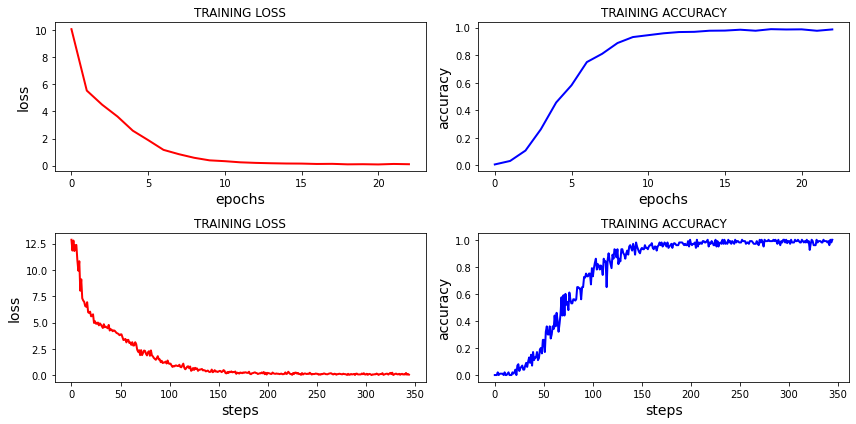

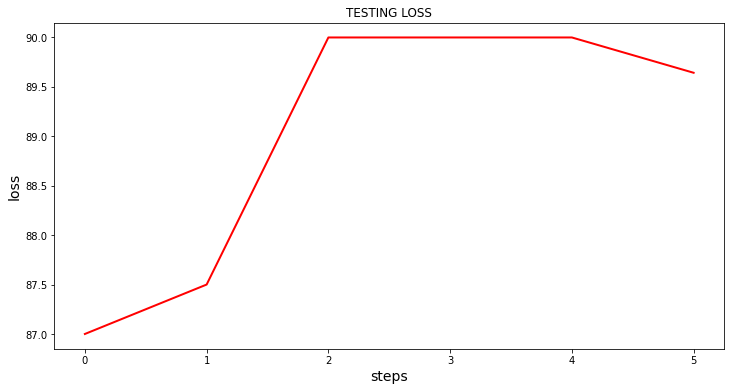

In [631]:
handler.plot_train_results()
handler.plot_test_results()